<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE1] - Building and training an AE denoiser model
<!-- DESC --> Episode 1 : After construction, the model is trained with noisy data from the MNIST dataset.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a denoizing **autoencoder** neurals network (AE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

Thanks to **François Chollet** whose VAE example has greatly inspired this example.  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks          import ImagesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from importlib import reload
from IPython.display import display,Image,Markdown,HTML
import h5py

from skimage import io
from skimage.util import random_noise

import modules.AE
from modules.AE           import AE
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('AE1')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : AE1
Run time             : Monday 01 March 2021, 20:32:41
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Prepare data
### 2.1 - Get MNIST dataset

In [2]:
x_data, y_data = Loader_MNIST.get()

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)


### 2.2 - Add noise to dataset
We will add noise to our input dataset (x_data)  
Our goal is to predict noiselessly data (y_data)

In [3]:
def noise_it(x_data, about):
    for i,image in enumerate(x_data):
        pwk.update_progress(about,i+1,len(x_data))
        image=random_noise(image, mode='gaussian', mean=0, var=0.3)
        image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        image=random_noise(image, mode='poisson') 
        image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        x_data[i]=image
    return x_data


# ---- What we want to predict
#
y_data = np.copy(x_data)

# ---- Add noise to input data
#
x_data = noise_it(x_data, 'Add noise to x_train :')


Add noise to x_train : [########################################] 100.0% of 70000


### 2.3 - Have a look

Noisy dataset (x_data) :  (70000, 28, 28, 1)
Clean dataset (y_data) :  (70000, 28, 28, 1)


<br>**Noisy images (input data)**

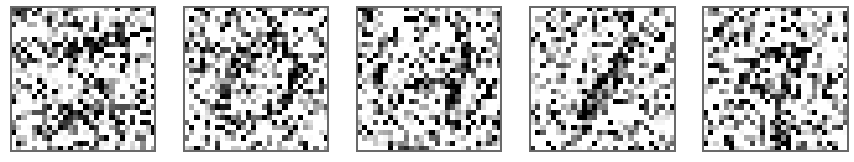

<br>**Original images we want to obtain (output data)**

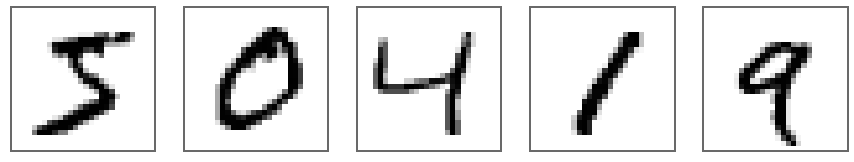

In [4]:
print('Noisy dataset (x_data) : ',x_data.shape)
print('Clean dataset (y_data) : ',y_data.shape)

pwk.subtitle('Noisy images (input data)')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='01-noisy')
pwk.subtitle('Original images we want to obtain (output data)')
pwk.plot_images(y_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='02-original')


### 2.4 - Shuffle and split dataset

In [5]:
p = np.random.permutation(len(x_data))
x_data, y_data = x_data[p], y_data[p]
x_train, y_train = x_data[:60000], y_data[:60000]
x_test,  y_test  = x_data[60000:], y_data[60000:]

print(f'x_train:{x_train.shape}  y_train:{y_train.shape}')
print(f'x_test :{x_test.shape}  y_test :{y_test.shape}')

x_train:(60000, 28, 28, 1)  y_train:(60000, 28, 28, 1)
x_test :(10000, 28, 28, 1)  y_test :(10000, 28, 28, 1)


### 2.5 - Save it

In [6]:
pwk.mkdir('./data')

with h5py.File('./data/mnist-noisy.h5', "w") as f:
    f.create_dataset("x_train", data=x_train)
    f.create_dataset("y_train", data=y_train)
    f.create_dataset("x_test",  data=x_test)
    f.create_dataset("y_test",  data=y_test)
    print('Saved.')

Saved.


## Step 3 - Build model

In [7]:
latent_dim = 10

#### Encoder

In [8]:
reload(modules.AE)
from modules.AE          import AE

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [9]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### AE


In [10]:
ae = AE(encoder, decoder)

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [11]:
# ---- Callback : Images
pwk.mkdir('./run/images')
filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=x_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
pwk.mkdir('./run/models')
filename = './run/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = './run/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]

In [12]:
%%time

n          = 60000
batch_size = 128
epochs     = 30

history = ae.fit(x_train[:n],y_train[:n], epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/30


  1/469 [..............................] - ETA: 27:52 - loss: 0.6932

  3/469 [..............................] - ETA: 20s - loss: 0.6922  

 15/469 [..............................] - ETA: 4s - loss: 0.6629 

 28/469 [>.............................] - ETA: 3s - loss: 0.5991

 40/469 [=>............................] - ETA: 2s - loss: 0.5513

 53/469 [==>...........................] - ETA: 2s - loss: 0.5131

 66/469 [===>..........................] - ETA: 2s - loss: 0.4846

 79/469 [====>.........................] - ETA: 2s - loss: 0.4624

 92/469 [====>.........................] - ETA: 1s - loss: 0.4448

106/469 [=====>........................] - ETA: 1s - loss: 0.4293

120/469 [======>.......................] - ETA: 1s - loss: 0.4165

134/469 [=======>......................] - ETA: 1s - loss: 0.4058

148/469 [========>.....................] - ETA: 1s - loss: 0.3966

162/469 [=========>....................] - ETA: 1s - loss: 0.3886

176/469 [==========>...................] - ETA: 1s - loss: 0.3816

190/469 [===========>..................] - ETA: 1s - loss: 0.3755

204/469 [============>.................] - ETA: 1s - loss: 0.3699

218/469 [============>.................] - ETA: 1s - loss: 0.3649

232/469 [=============>................] - ETA: 0s - loss: 0.3603

246/469 [==============>...............] - ETA: 0s - loss: 0.3561

255/469 [===============>..............] - ETA: 1s - loss: 0.3536

269/469 [================>.............] - ETA: 0s - loss: 0.3499

283/469 [=================>............] - ETA: 0s - loss: 0.3465

297/469 [=================>............] - ETA: 0s - loss: 0.3434

311/469 [==================>...........] - ETA: 0s - loss: 0.3404

325/469 [===================>..........] - ETA: 0s - loss: 0.3375

339/469 [====================>.........] - ETA: 0s - loss: 0.3348

353/469 [=====================>........] - ETA: 0s - loss: 0.3323

367/469 [======================>.......] - ETA: 0s - loss: 0.3299

381/469 [=======================>......] - ETA: 0s - loss: 0.3276

395/469 [========================>.....] - ETA: 0s - loss: 0.3253

409/469 [=========================>....] - ETA: 0s - loss: 0.3232

423/469 [==========================>...] - ETA: 0s - loss: 0.3212

437/469 [==========================>...] - ETA: 0s - loss: 0.3192

451/469 [===========================>..] - ETA: 0s - loss: 0.3173

465/469 [============================>.] - ETA: 0s - loss: 0.3154

469/469 [==============================] - ETA: 0s - loss: 0.3149

469/469 [==============================] - 6s 4ms/step - loss: 0.3148


           (saved) Epoch 2/30
  1/469 [..............................] - ETA: 1s - loss: 0.1967

 15/469 [..............................] - ETA: 1s - loss: 0.1966

 29/469 [>.............................] - ETA: 1s - loss: 0.1958

 43/469 [=>............................] - ETA: 1s - loss: 0.1955

 57/469 [==>...........................] - ETA: 1s - loss: 0.1950

 71/469 [===>..........................] - ETA: 1s - loss: 0.1946

 85/469 [====>.........................] - ETA: 1s - loss: 0.1942

 99/469 [=====>........................] - ETA: 1s - loss: 0.1938

113/469 [======>.......................] - ETA: 1s - loss: 0.1934

127/469 [=======>......................] - ETA: 1s - loss: 0.1931

141/469 [========>.....................] - ETA: 1s - loss: 0.1928

155/469 [========>.....................] - ETA: 1s - loss: 0.1925

169/469 [=========>....................] - ETA: 1s - loss: 0.1922

183/469 [==========>...................] - ETA: 1s - loss: 0.1919

197/469 [===========>..................] - ETA: 1s - loss: 0.1916

211/469 [============>.................] - ETA: 0s - loss: 0.1914

225/469 [=============>................] - ETA: 0s - loss: 0.1911

239/469 [==============>...............] - ETA: 0s - loss: 0.1909

253/469 [===============>..............] - ETA: 0s - loss: 0.1906

267/469 [================>.............] - ETA: 0s - loss: 0.1904

281/469 [================>.............] - ETA: 0s - loss: 0.1902

295/469 [=================>............] - ETA: 0s - loss: 0.1900

309/469 [==================>...........] - ETA: 0s - loss: 0.1897

323/469 [===================>..........] - ETA: 0s - loss: 0.1895

337/469 [====================>.........] - ETA: 0s - loss: 0.1893

351/469 [=====================>........] - ETA: 0s - loss: 0.1891

365/469 [======================>.......] - ETA: 0s - loss: 0.1888

379/469 [=======================>......] - ETA: 0s - loss: 0.1886

393/469 [========================>.....] - ETA: 0s - loss: 0.1884

407/469 [=========================>....] - ETA: 0s - loss: 0.1882

421/469 [=========================>....] - ETA: 0s - loss: 0.1880

435/469 [==========================>...] - ETA: 0s - loss: 0.1878

449/469 [===========================>..] - ETA: 0s - loss: 0.1876

463/469 [============================>.] - ETA: 0s - loss: 0.1873

469/469 [==============================] - 2s 4ms/step - loss: 0.1872


           (saved) 

Epoch 3/30
  1/469 [..............................] - ETA: 1s - loss: 0.1689

 15/469 [..............................] - ETA: 1s - loss: 0.1686

 29/469 [>.............................] - ETA: 1s - loss: 0.1681

 43/469 [=>............................] - ETA: 1s - loss: 0.1683

 57/469 [==>...........................] - ETA: 1s - loss: 0.1684

 71/469 [===>..........................] - ETA: 1s - loss: 0.1686

 85/469 [====>.........................] - ETA: 1s - loss: 0.1686

 99/469 [=====>........................] - ETA: 1s - loss: 0.1687

113/469 [======>.......................] - ETA: 1s - loss: 0.1687

127/469 [=======>......................] - ETA: 1s - loss: 0.1686

141/469 [========>.....................] - ETA: 1s - loss: 0.1685

155/469 [========>.....................] - ETA: 1s - loss: 0.1684

169/469 [=========>....................] - ETA: 1s - loss: 0.1683

183/469 [==========>...................] - ETA: 1s - loss: 0.1682

197/469 [===========>..................] - ETA: 1s - loss: 0.1681

211/469 [============>.................] - ETA: 0s - loss: 0.1681

225/469 [=============>................] - ETA: 0s - loss: 0.1680

239/469 [==============>...............] - ETA: 0s - loss: 0.1679

253/469 [===============>..............] - ETA: 0s - loss: 0.1678

267/469 [================>.............] - ETA: 0s - loss: 0.1678

281/469 [================>.............] - ETA: 0s - loss: 0.1677

295/469 [=================>............] - ETA: 0s - loss: 0.1676

309/469 [==================>...........] - ETA: 0s - loss: 0.1675

323/469 [===================>..........] - ETA: 0s - loss: 0.1675

337/469 [====================>.........] - ETA: 0s - loss: 0.1674

351/469 [=====================>........] - ETA: 0s - loss: 0.1673

365/469 [======================>.......] - ETA: 0s - loss: 0.1673

379/469 [=======================>......] - ETA: 0s - loss: 0.1672

393/469 [========================>.....] - ETA: 0s - loss: 0.1672

407/469 [=========================>....] - ETA: 0s - loss: 0.1671

421/469 [=========================>....] - ETA: 0s - loss: 0.1670

435/469 [==========================>...] - ETA: 0s - loss: 0.1670

449/469 [===========================>..] - ETA: 0s - loss: 0.1669

463/469 [============================>.] - ETA: 0s - loss: 0.1668

469/469 [==============================] - 2s 4ms/step - loss: 0.1668


           (saved) 

Epoch 4/30
  1/469 [..............................] - ETA: 2s - loss: 0.1541

 15/469 [..............................] - ETA: 1s - loss: 0.1602

 29/469 [>.............................] - ETA: 1s - loss: 0.1610

 43/469 [=>............................] - ETA: 1s - loss: 0.1610

 57/469 [==>...........................] - ETA: 1s - loss: 0.1610

 71/469 [===>..........................] - ETA: 1s - loss: 0.1609

 85/469 [====>.........................] - ETA: 1s - loss: 0.1608

 99/469 [=====>........................] - ETA: 1s - loss: 0.1607

113/469 [======>.......................] - ETA: 1s - loss: 0.1606

127/469 [=======>......................] - ETA: 1s - loss: 0.1605

141/469 [========>.....................] - ETA: 1s - loss: 0.1604

155/469 [========>.....................] - ETA: 1s - loss: 0.1604

169/469 [=========>....................] - ETA: 1s - loss: 0.1603

183/469 [==========>...................] - ETA: 1s - loss: 0.1602

197/469 [===========>..................] - ETA: 1s - loss: 0.1602

211/469 [============>.................] - ETA: 0s - loss: 0.1602

225/469 [=============>................] - ETA: 0s - loss: 0.1601

239/469 [==============>...............] - ETA: 0s - loss: 0.1601

253/469 [===============>..............] - ETA: 0s - loss: 0.1600

267/469 [================>.............] - ETA: 0s - loss: 0.1600

281/469 [================>.............] - ETA: 0s - loss: 0.1600

295/469 [=================>............] - ETA: 0s - loss: 0.1599

309/469 [==================>...........] - ETA: 0s - loss: 0.1599

323/469 [===================>..........] - ETA: 0s - loss: 0.1598

337/469 [====================>.........] - ETA: 0s - loss: 0.1598

351/469 [=====================>........] - ETA: 0s - loss: 0.1597

365/469 [======================>.......] - ETA: 0s - loss: 0.1597

379/469 [=======================>......] - ETA: 0s - loss: 0.1597

393/469 [========================>.....] - ETA: 0s - loss: 0.1596

407/469 [=========================>....] - ETA: 0s - loss: 0.1596

421/469 [=========================>....] - ETA: 0s - loss: 0.1595

435/469 [==========================>...] - ETA: 0s - loss: 0.1595

449/469 [===========================>..] - ETA: 0s - loss: 0.1595

463/469 [============================>.] - ETA: 0s - loss: 0.1594

469/469 [==============================] - 2s 4ms/step - loss: 0.1594


           (saved) Epoch 5/30
  1/469 [..............................] - ETA: 1s - loss: 0.1538

 15/469 [..............................] - ETA: 1s - loss: 0.1554

 29/469 [>.............................] - ETA: 1s - loss: 0.1553

 43/469 [=>............................] - ETA: 1s - loss: 0.1553

 57/469 [==>...........................] - ETA: 1s - loss: 0.1553

 71/469 [===>..........................] - ETA: 1s - loss: 0.1553

 85/469 [====>.........................] - ETA: 1s - loss: 0.1552

 99/469 [=====>........................] - ETA: 1s - loss: 0.1552

113/469 [======>.......................] - ETA: 1s - loss: 0.1552

127/469 [=======>......................] - ETA: 1s - loss: 0.1552

141/469 [========>.....................] - ETA: 1s - loss: 0.1552

155/469 [========>.....................] - ETA: 1s - loss: 0.1551

169/469 [=========>....................] - ETA: 1s - loss: 0.1551

183/469 [==========>...................] - ETA: 1s - loss: 0.1551

197/469 [===========>..................] - ETA: 1s - loss: 0.1551

211/469 [============>.................] - ETA: 0s - loss: 0.1551

225/469 [=============>................] - ETA: 0s - loss: 0.1551

239/469 [==============>...............] - ETA: 0s - loss: 0.1551

253/469 [===============>..............] - ETA: 0s - loss: 0.1550

267/469 [================>.............] - ETA: 0s - loss: 0.1550

281/469 [================>.............] - ETA: 0s - loss: 0.1550

295/469 [=================>............] - ETA: 0s - loss: 0.1550

309/469 [==================>...........] - ETA: 0s - loss: 0.1550

323/469 [===================>..........] - ETA: 0s - loss: 0.1550

337/469 [====================>.........] - ETA: 0s - loss: 0.1550

351/469 [=====================>........] - ETA: 0s - loss: 0.1550

365/469 [======================>.......] - ETA: 0s - loss: 0.1549

379/469 [=======================>......] - ETA: 0s - loss: 0.1549

393/469 [========================>.....] - ETA: 0s - loss: 0.1549

407/469 [=========================>....] - ETA: 0s - loss: 0.1549

421/469 [=========================>....] - ETA: 0s - loss: 0.1549

435/469 [==========================>...] - ETA: 0s - loss: 0.1549

449/469 [===========================>..] - ETA: 0s - loss: 0.1549

463/469 [============================>.] - ETA: 0s - loss: 0.1549

469/469 [==============================] - 2s 4ms/step - loss: 0.1549


           (saved) 

Epoch 6/30
  1/469 [..............................] - ETA: 2s - loss: 0.1533

 15/469 [..............................] - ETA: 1s - loss: 0.1520

 29/469 [>.............................] - ETA: 1s - loss: 0.1522

 43/469 [=>............................] - ETA: 1s - loss: 0.1522

 57/469 [==>...........................] - ETA: 1s - loss: 0.1523

 71/469 [===>..........................] - ETA: 1s - loss: 0.1524

 85/469 [====>.........................] - ETA: 1s - loss: 0.1524

 99/469 [=====>........................] - ETA: 1s - loss: 0.1524

113/469 [======>.......................] - ETA: 1s - loss: 0.1525

127/469 [=======>......................] - ETA: 1s - loss: 0.1525

141/469 [========>.....................] - ETA: 1s - loss: 0.1525

155/469 [========>.....................] - ETA: 1s - loss: 0.1525

169/469 [=========>....................] - ETA: 1s - loss: 0.1525

183/469 [==========>...................] - ETA: 1s - loss: 0.1525

197/469 [===========>..................] - ETA: 1s - loss: 0.1525

211/469 [============>.................] - ETA: 0s - loss: 0.1526

225/469 [=============>................] - ETA: 0s - loss: 0.1526

239/469 [==============>...............] - ETA: 0s - loss: 0.1526

253/469 [===============>..............] - ETA: 0s - loss: 0.1526

267/469 [================>.............] - ETA: 0s - loss: 0.1526

281/469 [================>.............] - ETA: 0s - loss: 0.1526

295/469 [=================>............] - ETA: 0s - loss: 0.1526

309/469 [==================>...........] - ETA: 0s - loss: 0.1526

323/469 [===================>..........] - ETA: 0s - loss: 0.1526

337/469 [====================>.........] - ETA: 0s - loss: 0.1526

351/469 [=====================>........] - ETA: 0s - loss: 0.1526

365/469 [======================>.......] - ETA: 0s - loss: 0.1526

379/469 [=======================>......] - ETA: 0s - loss: 0.1526

393/469 [========================>.....] - ETA: 0s - loss: 0.1526

407/469 [=========================>....] - ETA: 0s - loss: 0.1526

421/469 [=========================>....] - ETA: 0s - loss: 0.1526

435/469 [==========================>...] - ETA: 0s - loss: 0.1526

449/469 [===========================>..] - ETA: 0s - loss: 0.1526

463/469 [============================>.] - ETA: 0s - loss: 0.1526

469/469 [==============================] - 2s 4ms/step - loss: 0.1526


           (saved) 

Epoch 7/30
  1/469 [..............................] - ETA: 1s - loss: 0.1485

 15/469 [..............................] - ETA: 1s - loss: 0.1490

 29/469 [>.............................] - ETA: 1s - loss: 0.1497

 43/469 [=>............................] - ETA: 1s - loss: 0.1500

 57/469 [==>...........................] - ETA: 1s - loss: 0.1502

 71/469 [===>..........................] - ETA: 1s - loss: 0.1504

 85/469 [====>.........................] - ETA: 1s - loss: 0.1504

 99/469 [=====>........................] - ETA: 1s - loss: 0.1505

113/469 [======>.......................] - ETA: 1s - loss: 0.1505

127/469 [=======>......................] - ETA: 1s - loss: 0.1505

141/469 [========>.....................] - ETA: 1s - loss: 0.1505

155/469 [========>.....................] - ETA: 1s - loss: 0.1505

169/469 [=========>....................] - ETA: 1s - loss: 0.1505

183/469 [==========>...................] - ETA: 1s - loss: 0.1505

197/469 [===========>..................] - ETA: 1s - loss: 0.1505

211/469 [============>.................] - ETA: 0s - loss: 0.1505

225/469 [=============>................] - ETA: 0s - loss: 0.1505

239/469 [==============>...............] - ETA: 0s - loss: 0.1506

253/469 [===============>..............] - ETA: 0s - loss: 0.1506

267/469 [================>.............] - ETA: 0s - loss: 0.1506

281/469 [================>.............] - ETA: 0s - loss: 0.1506

295/469 [=================>............] - ETA: 0s - loss: 0.1506

309/469 [==================>...........] - ETA: 0s - loss: 0.1506

323/469 [===================>..........] - ETA: 0s - loss: 0.1506

337/469 [====================>.........] - ETA: 0s - loss: 0.1506

351/469 [=====================>........] - ETA: 0s - loss: 0.1506

365/469 [======================>.......] - ETA: 0s - loss: 0.1506

379/469 [=======================>......] - ETA: 0s - loss: 0.1506

393/469 [========================>.....] - ETA: 0s - loss: 0.1506

407/469 [=========================>....] - ETA: 0s - loss: 0.1506

421/469 [=========================>....] - ETA: 0s - loss: 0.1506

435/469 [==========================>...] - ETA: 0s - loss: 0.1506

449/469 [===========================>..] - ETA: 0s - loss: 0.1506

463/469 [============================>.] - ETA: 0s - loss: 0.1506

469/469 [==============================] - 2s 4ms/step - loss: 0.1506


           (saved) 

Epoch 8/30
  1/469 [..............................] - ETA: 1s - loss: 0.1517

 15/469 [..............................] - ETA: 1s - loss: 0.1514

 29/469 [>.............................] - ETA: 1s - loss: 0.1510

 43/469 [=>............................] - ETA: 1s - loss: 0.1507

 57/469 [==>...........................] - ETA: 1s - loss: 0.1506

 71/469 [===>..........................] - ETA: 1s - loss: 0.1505

 85/469 [====>.........................] - ETA: 1s - loss: 0.1505

 99/469 [=====>........................] - ETA: 1s - loss: 0.1504

113/469 [======>.......................] - ETA: 1s - loss: 0.1504

127/469 [=======>......................] - ETA: 1s - loss: 0.1503

141/469 [========>.....................] - ETA: 1s - loss: 0.1502

155/469 [========>.....................] - ETA: 1s - loss: 0.1502

169/469 [=========>....................] - ETA: 1s - loss: 0.1501

183/469 [==========>...................] - ETA: 1s - loss: 0.1501

197/469 [===========>..................] - ETA: 1s - loss: 0.1500

211/469 [============>.................] - ETA: 0s - loss: 0.1500

225/469 [=============>................] - ETA: 0s - loss: 0.1500

239/469 [==============>...............] - ETA: 0s - loss: 0.1499

253/469 [===============>..............] - ETA: 0s - loss: 0.1499

267/469 [================>.............] - ETA: 0s - loss: 0.1499

281/469 [================>.............] - ETA: 0s - loss: 0.1498

295/469 [=================>............] - ETA: 0s - loss: 0.1498

309/469 [==================>...........] - ETA: 0s - loss: 0.1498

323/469 [===================>..........] - ETA: 0s - loss: 0.1498

337/469 [====================>.........] - ETA: 0s - loss: 0.1498

351/469 [=====================>........] - ETA: 0s - loss: 0.1498

365/469 [======================>.......] - ETA: 0s - loss: 0.1497

379/469 [=======================>......] - ETA: 0s - loss: 0.1497

393/469 [========================>.....] - ETA: 0s - loss: 0.1497

407/469 [=========================>....] - ETA: 0s - loss: 0.1497

421/469 [=========================>....] - ETA: 0s - loss: 0.1497

435/469 [==========================>...] - ETA: 0s - loss: 0.1497

449/469 [===========================>..] - ETA: 0s - loss: 0.1497

463/469 [============================>.] - ETA: 0s - loss: 0.1497

469/469 [==============================] - 2s 4ms/step - loss: 0.1496


           (saved) 

Epoch 9/30


  1/469 [..............................] - ETA: 1s - loss: 0.1500

 15/469 [..............................] - ETA: 1s - loss: 0.1474

 29/469 [>.............................] - ETA: 1s - loss: 0.1474

 43/469 [=>............................] - ETA: 1s - loss: 0.1475

 57/469 [==>...........................] - ETA: 1s - loss: 0.1476

 71/469 [===>..........................] - ETA: 1s - loss: 0.1477

 85/469 [====>.........................] - ETA: 1s - loss: 0.1477

 99/469 [=====>........................] - ETA: 1s - loss: 0.1478

113/469 [======>.......................] - ETA: 1s - loss: 0.1478

127/469 [=======>......................] - ETA: 1s - loss: 0.1479

141/469 [========>.....................] - ETA: 1s - loss: 0.1479

155/469 [========>.....................] - ETA: 1s - loss: 0.1480

169/469 [=========>....................] - ETA: 1s - loss: 0.1480

183/469 [==========>...................] - ETA: 1s - loss: 0.1480

197/469 [===========>..................] - ETA: 1s - loss: 0.1480

211/469 [============>.................] - ETA: 0s - loss: 0.1481

225/469 [=============>................] - ETA: 0s - loss: 0.1481

239/469 [==============>...............] - ETA: 0s - loss: 0.1481

253/469 [===============>..............] - ETA: 0s - loss: 0.1481

267/469 [================>.............] - ETA: 0s - loss: 0.1481

281/469 [================>.............] - ETA: 0s - loss: 0.1481

295/469 [=================>............] - ETA: 0s - loss: 0.1481

309/469 [==================>...........] - ETA: 0s - loss: 0.1481

323/469 [===================>..........] - ETA: 0s - loss: 0.1481

337/469 [====================>.........] - ETA: 0s - loss: 0.1481

351/469 [=====================>........] - ETA: 0s - loss: 0.1482

365/469 [======================>.......] - ETA: 0s - loss: 0.1482

379/469 [=======================>......] - ETA: 0s - loss: 0.1482

393/469 [========================>.....] - ETA: 0s - loss: 0.1482

407/469 [=========================>....] - ETA: 0s - loss: 0.1482

421/469 [=========================>....] - ETA: 0s - loss: 0.1482

435/469 [==========================>...] - ETA: 0s - loss: 0.1482

449/469 [===========================>..] - ETA: 0s - loss: 0.1482

463/469 [============================>.] - ETA: 0s - loss: 0.1482

469/469 [==============================] - 2s 4ms/step - loss: 0.1482


           (saved) Epoch 10/30
  1/469 [..............................] - ETA: 1s - loss: 0.1467

 15/469 [..............................] - ETA: 1s - loss: 0.1463

 29/469 [>.............................] - ETA: 1s - loss: 0.1465

 43/469 [=>............................] - ETA: 1s - loss: 0.1467

 57/469 [==>...........................] - ETA: 1s - loss: 0.1469

 71/469 [===>..........................] - ETA: 1s - loss: 0.1470

 85/469 [====>.........................] - ETA: 1s - loss: 0.1470

 99/469 [=====>........................] - ETA: 1s - loss: 0.1469

113/469 [======>.......................] - ETA: 1s - loss: 0.1469

127/469 [=======>......................] - ETA: 1s - loss: 0.1469

141/469 [========>.....................] - ETA: 1s - loss: 0.1468

155/469 [========>.....................] - ETA: 1s - loss: 0.1468

169/469 [=========>....................] - ETA: 1s - loss: 0.1468

183/469 [==========>...................] - ETA: 1s - loss: 0.1468

197/469 [===========>..................] - ETA: 1s - loss: 0.1468

211/469 [============>.................] - ETA: 0s - loss: 0.1468

225/469 [=============>................] - ETA: 0s - loss: 0.1468

239/469 [==============>...............] - ETA: 0s - loss: 0.1468

253/469 [===============>..............] - ETA: 0s - loss: 0.1469

267/469 [================>.............] - ETA: 0s - loss: 0.1469

281/469 [================>.............] - ETA: 0s - loss: 0.1469

295/469 [=================>............] - ETA: 0s - loss: 0.1469

309/469 [==================>...........] - ETA: 0s - loss: 0.1469

323/469 [===================>..........] - ETA: 0s - loss: 0.1469

337/469 [====================>.........] - ETA: 0s - loss: 0.1469

351/469 [=====================>........] - ETA: 0s - loss: 0.1470

365/469 [======================>.......] - ETA: 0s - loss: 0.1470

379/469 [=======================>......] - ETA: 0s - loss: 0.1470

393/469 [========================>.....] - ETA: 0s - loss: 0.1470

407/469 [=========================>....] - ETA: 0s - loss: 0.1470

421/469 [=========================>....] - ETA: 0s - loss: 0.1470

435/469 [==========================>...] - ETA: 0s - loss: 0.1470

449/469 [===========================>..] - ETA: 0s - loss: 0.1470

463/469 [============================>.] - ETA: 0s - loss: 0.1470

469/469 [==============================] - 2s 4ms/step - loss: 0.1470


           (saved) 

Epoch 11/30
  1/469 [..............................] - ETA: 1s - loss: 0.1478

 15/469 [..............................] - ETA: 1s - loss: 0.1477

 29/469 [>.............................] - ETA: 1s - loss: 0.1472

 43/469 [=>............................] - ETA: 1s - loss: 0.1471

 57/469 [==>...........................] - ETA: 1s - loss: 0.1469

 71/469 [===>..........................] - ETA: 1s - loss: 0.1469

 85/469 [====>.........................] - ETA: 1s - loss: 0.1468

 98/469 [=====>........................] - ETA: 1s - loss: 0.1468

111/469 [======>.......................] - ETA: 1s - loss: 0.1468

124/469 [======>.......................] - ETA: 1s - loss: 0.1467

137/469 [=======>......................] - ETA: 1s - loss: 0.1467

150/469 [========>.....................] - ETA: 1s - loss: 0.1467

163/469 [=========>....................] - ETA: 1s - loss: 0.1467

176/469 [==========>...................] - ETA: 1s - loss: 0.1466

189/469 [===========>..................] - ETA: 1s - loss: 0.1466

202/469 [===========>..................] - ETA: 1s - loss: 0.1466

215/469 [============>.................] - ETA: 0s - loss: 0.1466

228/469 [=============>................] - ETA: 0s - loss: 0.1466

241/469 [==============>...............] - ETA: 0s - loss: 0.1465

254/469 [===============>..............] - ETA: 0s - loss: 0.1465

267/469 [================>.............] - ETA: 0s - loss: 0.1465

280/469 [================>.............] - ETA: 0s - loss: 0.1465

293/469 [=================>............] - ETA: 0s - loss: 0.1465

306/469 [==================>...........] - ETA: 0s - loss: 0.1465

319/469 [===================>..........] - ETA: 0s - loss: 0.1465

332/469 [====================>.........] - ETA: 0s - loss: 0.1465

345/469 [=====================>........] - ETA: 0s - loss: 0.1465

358/469 [=====================>........] - ETA: 0s - loss: 0.1465

371/469 [======================>.......] - ETA: 0s - loss: 0.1465

384/469 [=======================>......] - ETA: 0s - loss: 0.1465

397/469 [========================>.....] - ETA: 0s - loss: 0.1465

410/469 [=========================>....] - ETA: 0s - loss: 0.1465

423/469 [==========================>...] - ETA: 0s - loss: 0.1465

436/469 [==========================>...] - ETA: 0s - loss: 0.1465

449/469 [===========================>..] - ETA: 0s - loss: 0.1465

462/469 [============================>.] - ETA: 0s - loss: 0.1465

469/469 [==============================] - 2s 4ms/step - loss: 0.1465


           (saved) 

Epoch 12/30
  1/469 [..............................] - ETA: 2s - loss: 0.1400

 14/469 [..............................] - ETA: 1s - loss: 0.1431

 27/469 [>.............................] - ETA: 1s - loss: 0.1435

 40/469 [=>............................] - ETA: 1s - loss: 0.1440

 53/469 [==>...........................] - ETA: 1s - loss: 0.1444

 66/469 [===>..........................] - ETA: 1s - loss: 0.1446

 79/469 [====>.........................] - ETA: 1s - loss: 0.1448

 92/469 [====>.........................] - ETA: 1s - loss: 0.1449

105/469 [=====>........................] - ETA: 1s - loss: 0.1450

118/469 [======>.......................] - ETA: 1s - loss: 0.1451

131/469 [=======>......................] - ETA: 1s - loss: 0.1452

144/469 [========>.....................] - ETA: 1s - loss: 0.1453

157/469 [=========>....................] - ETA: 1s - loss: 0.1453

170/469 [=========>....................] - ETA: 1s - loss: 0.1454

183/469 [==========>...................] - ETA: 1s - loss: 0.1454

196/469 [===========>..................] - ETA: 1s - loss: 0.1454

209/469 [============>.................] - ETA: 1s - loss: 0.1455

222/469 [=============>................] - ETA: 0s - loss: 0.1455

235/469 [==============>...............] - ETA: 0s - loss: 0.1455

248/469 [==============>...............] - ETA: 0s - loss: 0.1455

261/469 [===============>..............] - ETA: 0s - loss: 0.1455

274/469 [================>.............] - ETA: 0s - loss: 0.1455

287/469 [=================>............] - ETA: 0s - loss: 0.1456

300/469 [==================>...........] - ETA: 0s - loss: 0.1456

313/469 [===================>..........] - ETA: 0s - loss: 0.1456

326/469 [===================>..........] - ETA: 0s - loss: 0.1456

339/469 [====================>.........] - ETA: 0s - loss: 0.1456

352/469 [=====================>........] - ETA: 0s - loss: 0.1456

365/469 [======================>.......] - ETA: 0s - loss: 0.1456

378/469 [=======================>......] - ETA: 0s - loss: 0.1457

391/469 [========================>.....] - ETA: 0s - loss: 0.1457

404/469 [========================>.....] - ETA: 0s - loss: 0.1457

417/469 [=========================>....] - ETA: 0s - loss: 0.1457

430/469 [==========================>...] - ETA: 0s - loss: 0.1457

443/469 [===========================>..] - ETA: 0s - loss: 0.1457

456/469 [============================>.] - ETA: 0s - loss: 0.1457

469/469 [==============================] - ETA: 0s - loss: 0.1457

469/469 [==============================] - 2s 4ms/step - loss: 0.1457


           (saved) 

Epoch 13/30
  1/469 [..............................] - ETA: 2s - loss: 0.1427

 14/469 [..............................] - ETA: 1s - loss: 0.1447

 27/469 [>.............................] - ETA: 1s - loss: 0.1447

 40/469 [=>............................] - ETA: 1s - loss: 0.1446

 53/469 [==>...........................] - ETA: 1s - loss: 0.1447

 66/469 [===>..........................] - ETA: 1s - loss: 0.1447

 79/469 [====>.........................] - ETA: 1s - loss: 0.1447

 92/469 [====>.........................] - ETA: 1s - loss: 0.1447

105/469 [=====>........................] - ETA: 1s - loss: 0.1447

118/469 [======>.......................] - ETA: 1s - loss: 0.1446

131/469 [=======>......................] - ETA: 1s - loss: 0.1446

144/469 [========>.....................] - ETA: 1s - loss: 0.1446

157/469 [=========>....................] - ETA: 1s - loss: 0.1446

170/469 [=========>....................] - ETA: 1s - loss: 0.1446

183/469 [==========>...................] - ETA: 1s - loss: 0.1447

196/469 [===========>..................] - ETA: 1s - loss: 0.1447

209/469 [============>.................] - ETA: 1s - loss: 0.1447

222/469 [=============>................] - ETA: 0s - loss: 0.1447

235/469 [==============>...............] - ETA: 0s - loss: 0.1447

248/469 [==============>...............] - ETA: 0s - loss: 0.1447

261/469 [===============>..............] - ETA: 0s - loss: 0.1447

274/469 [================>.............] - ETA: 0s - loss: 0.1447

287/469 [=================>............] - ETA: 0s - loss: 0.1448

300/469 [==================>...........] - ETA: 0s - loss: 0.1448

313/469 [===================>..........] - ETA: 0s - loss: 0.1448

326/469 [===================>..........] - ETA: 0s - loss: 0.1448

339/469 [====================>.........] - ETA: 0s - loss: 0.1448

352/469 [=====================>........] - ETA: 0s - loss: 0.1448

365/469 [======================>.......] - ETA: 0s - loss: 0.1448

378/469 [=======================>......] - ETA: 0s - loss: 0.1448

391/469 [========================>.....] - ETA: 0s - loss: 0.1448

404/469 [========================>.....] - ETA: 0s - loss: 0.1449

417/469 [=========================>....] - ETA: 0s - loss: 0.1449

430/469 [==========================>...] - ETA: 0s - loss: 0.1449

443/469 [===========================>..] - ETA: 0s - loss: 0.1449

456/469 [============================>.] - ETA: 0s - loss: 0.1449

469/469 [==============================] - ETA: 0s - loss: 0.1449

469/469 [==============================] - 2s 4ms/step - loss: 0.1449


           (saved) 

Epoch 14/30
  1/469 [..............................] - ETA: 2s - loss: 0.1461

 14/469 [..............................] - ETA: 1s - loss: 0.1447

 27/469 [>.............................] - ETA: 1s - loss: 0.1446

 40/469 [=>............................] - ETA: 1s - loss: 0.1445

 53/469 [==>...........................] - ETA: 1s - loss: 0.1444

 66/469 [===>..........................] - ETA: 1s - loss: 0.1443

 79/469 [====>.........................] - ETA: 1s - loss: 0.1443

 92/469 [====>.........................] - ETA: 1s - loss: 0.1442

105/469 [=====>........................] - ETA: 1s - loss: 0.1442

118/469 [======>.......................] - ETA: 1s - loss: 0.1442

131/469 [=======>......................] - ETA: 1s - loss: 0.1442

144/469 [========>.....................] - ETA: 1s - loss: 0.1442

157/469 [=========>....................] - ETA: 1s - loss: 0.1442

170/469 [=========>....................] - ETA: 1s - loss: 0.1442

183/469 [==========>...................] - ETA: 1s - loss: 0.1442

196/469 [===========>..................] - ETA: 1s - loss: 0.1442

209/469 [============>.................] - ETA: 1s - loss: 0.1442

222/469 [=============>................] - ETA: 0s - loss: 0.1442

235/469 [==============>...............] - ETA: 0s - loss: 0.1442

248/469 [==============>...............] - ETA: 0s - loss: 0.1443

261/469 [===============>..............] - ETA: 0s - loss: 0.1443

274/469 [================>.............] - ETA: 0s - loss: 0.1443

287/469 [=================>............] - ETA: 0s - loss: 0.1443

300/469 [==================>...........] - ETA: 0s - loss: 0.1443

313/469 [===================>..........] - ETA: 0s - loss: 0.1443

326/469 [===================>..........] - ETA: 0s - loss: 0.1443

339/469 [====================>.........] - ETA: 0s - loss: 0.1443

352/469 [=====================>........] - ETA: 0s - loss: 0.1443

365/469 [======================>.......] - ETA: 0s - loss: 0.1443

378/469 [=======================>......] - ETA: 0s - loss: 0.1443

391/469 [========================>.....] - ETA: 0s - loss: 0.1443

404/469 [========================>.....] - ETA: 0s - loss: 0.1444

417/469 [=========================>....] - ETA: 0s - loss: 0.1444

430/469 [==========================>...] - ETA: 0s - loss: 0.1444

443/469 [===========================>..] - ETA: 0s - loss: 0.1444

456/469 [============================>.] - ETA: 0s - loss: 0.1444

469/469 [==============================] - ETA: 0s - loss: 0.1444

469/469 [==============================] - 2s 4ms/step - loss: 0.1444


           (saved) Epoch 15/30
  1/469 [..............................] - ETA: 2s - loss: 0.1392

 14/469 [..............................] - ETA: 1s - loss: 0.1410

 27/469 [>.............................] - ETA: 1s - loss: 0.1421

 40/469 [=>............................] - ETA: 1s - loss: 0.1427

 53/469 [==>...........................] - ETA: 1s - loss: 0.1429

 66/469 [===>..........................] - ETA: 1s - loss: 0.1431

 79/469 [====>.........................] - ETA: 1s - loss: 0.1432

 92/469 [====>.........................] - ETA: 1s - loss: 0.1433

105/469 [=====>........................] - ETA: 1s - loss: 0.1434

118/469 [======>.......................] - ETA: 1s - loss: 0.1434

131/469 [=======>......................] - ETA: 1s - loss: 0.1435

144/469 [========>.....................] - ETA: 1s - loss: 0.1435

157/469 [=========>....................] - ETA: 1s - loss: 0.1436

170/469 [=========>....................] - ETA: 1s - loss: 0.1436

183/469 [==========>...................] - ETA: 1s - loss: 0.1436

196/469 [===========>..................] - ETA: 1s - loss: 0.1437

209/469 [============>.................] - ETA: 1s - loss: 0.1437

222/469 [=============>................] - ETA: 0s - loss: 0.1437

235/469 [==============>...............] - ETA: 0s - loss: 0.1438

248/469 [==============>...............] - ETA: 0s - loss: 0.1438

261/469 [===============>..............] - ETA: 0s - loss: 0.1438

274/469 [================>.............] - ETA: 0s - loss: 0.1438

287/469 [=================>............] - ETA: 0s - loss: 0.1438

300/469 [==================>...........] - ETA: 0s - loss: 0.1439

313/469 [===================>..........] - ETA: 0s - loss: 0.1439

326/469 [===================>..........] - ETA: 0s - loss: 0.1439

339/469 [====================>.........] - ETA: 0s - loss: 0.1439

352/469 [=====================>........] - ETA: 0s - loss: 0.1439

365/469 [======================>.......] - ETA: 0s - loss: 0.1439

378/469 [=======================>......] - ETA: 0s - loss: 0.1439

391/469 [========================>.....] - ETA: 0s - loss: 0.1439

404/469 [========================>.....] - ETA: 0s - loss: 0.1439

417/469 [=========================>....] - ETA: 0s - loss: 0.1439

430/469 [==========================>...] - ETA: 0s - loss: 0.1439

443/469 [===========================>..] - ETA: 0s - loss: 0.1440

456/469 [============================>.] - ETA: 0s - loss: 0.1440

469/469 [==============================] - ETA: 0s - loss: 0.1440

469/469 [==============================] - 2s 4ms/step - loss: 0.1440


           (saved) Epoch 16/30
  1/469 [..............................] - ETA: 2s - loss: 0.1450

 13/469 [..............................] - ETA: 1s - loss: 0.1426

 26/469 [>.............................] - ETA: 1s - loss: 0.1427

 39/469 [=>............................] - ETA: 1s - loss: 0.1431

 52/469 [==>...........................] - ETA: 1s - loss: 0.1433

 65/469 [===>..........................] - ETA: 1s - loss: 0.1434

 79/469 [====>.........................] - ETA: 1s - loss: 0.1435

 93/469 [====>.........................] - ETA: 1s - loss: 0.1436

107/469 [=====>........................] - ETA: 1s - loss: 0.1436

121/469 [======>.......................] - ETA: 1s - loss: 0.1437

135/469 [=======>......................] - ETA: 1s - loss: 0.1437

149/469 [========>.....................] - ETA: 1s - loss: 0.1437

163/469 [=========>....................] - ETA: 1s - loss: 0.1437

177/469 [==========>...................] - ETA: 1s - loss: 0.1437

191/469 [===========>..................] - ETA: 1s - loss: 0.1437

205/469 [============>.................] - ETA: 1s - loss: 0.1437

219/469 [=============>................] - ETA: 0s - loss: 0.1437

233/469 [=============>................] - ETA: 0s - loss: 0.1437

247/469 [==============>...............] - ETA: 0s - loss: 0.1437

261/469 [===============>..............] - ETA: 0s - loss: 0.1437

275/469 [================>.............] - ETA: 0s - loss: 0.1437

289/469 [=================>............] - ETA: 0s - loss: 0.1437

303/469 [==================>...........] - ETA: 0s - loss: 0.1437

317/469 [===================>..........] - ETA: 0s - loss: 0.1437

331/469 [====================>.........] - ETA: 0s - loss: 0.1437

345/469 [=====================>........] - ETA: 0s - loss: 0.1437

359/469 [=====================>........] - ETA: 0s - loss: 0.1437

373/469 [======================>.......] - ETA: 0s - loss: 0.1437

387/469 [=======================>......] - ETA: 0s - loss: 0.1437

401/469 [========================>.....] - ETA: 0s - loss: 0.1437

415/469 [=========================>....] - ETA: 0s - loss: 0.1437

429/469 [==========================>...] - ETA: 0s - loss: 0.1437

443/469 [===========================>..] - ETA: 0s - loss: 0.1437

457/469 [============================>.] - ETA: 0s - loss: 0.1437

469/469 [==============================] - 2s 4ms/step - loss: 0.1437


           (saved) Epoch 17/30
  1/469 [..............................] - ETA: 1s - loss: 0.1364

 15/469 [..............................] - ETA: 1s - loss: 0.1426

 29/469 [>.............................] - ETA: 1s - loss: 0.1427

 43/469 [=>............................] - ETA: 1s - loss: 0.1427

 57/469 [==>...........................] - ETA: 1s - loss: 0.1428

 71/469 [===>..........................] - ETA: 1s - loss: 0.1428

 85/469 [====>.........................] - ETA: 1s - loss: 0.1429

 99/469 [=====>........................] - ETA: 1s - loss: 0.1429

113/469 [======>.......................] - ETA: 1s - loss: 0.1429

127/469 [=======>......................] - ETA: 1s - loss: 0.1429

141/469 [========>.....................] - ETA: 1s - loss: 0.1429

155/469 [========>.....................] - ETA: 1s - loss: 0.1429

169/469 [=========>....................] - ETA: 1s - loss: 0.1429

183/469 [==========>...................] - ETA: 1s - loss: 0.1429

197/469 [===========>..................] - ETA: 1s - loss: 0.1429

211/469 [============>.................] - ETA: 0s - loss: 0.1429

225/469 [=============>................] - ETA: 0s - loss: 0.1429

239/469 [==============>...............] - ETA: 0s - loss: 0.1430

253/469 [===============>..............] - ETA: 0s - loss: 0.1430

267/469 [================>.............] - ETA: 0s - loss: 0.1430

281/469 [================>.............] - ETA: 0s - loss: 0.1430

295/469 [=================>............] - ETA: 0s - loss: 0.1430

309/469 [==================>...........] - ETA: 0s - loss: 0.1430

323/469 [===================>..........] - ETA: 0s - loss: 0.1430

337/469 [====================>.........] - ETA: 0s - loss: 0.1430

351/469 [=====================>........] - ETA: 0s - loss: 0.1431

365/469 [======================>.......] - ETA: 0s - loss: 0.1431

379/469 [=======================>......] - ETA: 0s - loss: 0.1431

393/469 [========================>.....] - ETA: 0s - loss: 0.1431

407/469 [=========================>....] - ETA: 0s - loss: 0.1431

421/469 [=========================>....] - ETA: 0s - loss: 0.1431

435/469 [==========================>...] - ETA: 0s - loss: 0.1431

449/469 [===========================>..] - ETA: 0s - loss: 0.1431

463/469 [============================>.] - ETA: 0s - loss: 0.1431

469/469 [==============================] - 2s 4ms/step - loss: 0.1431


           (saved) Epoch 18/30
  1/469 [..............................] - ETA: 1s - loss: 0.1416

 15/469 [..............................] - ETA: 1s - loss: 0.1431

 29/469 [>.............................] - ETA: 1s - loss: 0.1428

 43/469 [=>............................] - ETA: 1s - loss: 0.1427

 57/469 [==>...........................] - ETA: 1s - loss: 0.1427

 71/469 [===>..........................] - ETA: 1s - loss: 0.1427

 85/469 [====>.........................] - ETA: 1s - loss: 0.1427

 99/469 [=====>........................] - ETA: 1s - loss: 0.1426

113/469 [======>.......................] - ETA: 1s - loss: 0.1426

127/469 [=======>......................] - ETA: 1s - loss: 0.1426

141/469 [========>.....................] - ETA: 1s - loss: 0.1426

155/469 [========>.....................] - ETA: 1s - loss: 0.1426

169/469 [=========>....................] - ETA: 1s - loss: 0.1425

183/469 [==========>...................] - ETA: 1s - loss: 0.1425

197/469 [===========>..................] - ETA: 1s - loss: 0.1425

211/469 [============>.................] - ETA: 0s - loss: 0.1425

225/469 [=============>................] - ETA: 0s - loss: 0.1425

239/469 [==============>...............] - ETA: 0s - loss: 0.1425

253/469 [===============>..............] - ETA: 0s - loss: 0.1425

267/469 [================>.............] - ETA: 0s - loss: 0.1425

281/469 [================>.............] - ETA: 0s - loss: 0.1425

295/469 [=================>............] - ETA: 0s - loss: 0.1425

309/469 [==================>...........] - ETA: 0s - loss: 0.1426

323/469 [===================>..........] - ETA: 0s - loss: 0.1426

337/469 [====================>.........] - ETA: 0s - loss: 0.1426

351/469 [=====================>........] - ETA: 0s - loss: 0.1426

365/469 [======================>.......] - ETA: 0s - loss: 0.1426

379/469 [=======================>......] - ETA: 0s - loss: 0.1426

393/469 [========================>.....] - ETA: 0s - loss: 0.1426

407/469 [=========================>....] - ETA: 0s - loss: 0.1426

421/469 [=========================>....] - ETA: 0s - loss: 0.1426

435/469 [==========================>...] - ETA: 0s - loss: 0.1426

449/469 [===========================>..] - ETA: 0s - loss: 0.1427

463/469 [============================>.] - ETA: 0s - loss: 0.1427

469/469 [==============================] - 2s 4ms/step - loss: 0.1427


           (saved) 

Epoch 19/30
  1/469 [..............................] - ETA: 1s - loss: 0.1371

 15/469 [..............................] - ETA: 1s - loss: 0.1409

 29/469 [>.............................] - ETA: 1s - loss: 0.1415

 43/469 [=>............................] - ETA: 1s - loss: 0.1418

 57/469 [==>...........................] - ETA: 1s - loss: 0.1419

 71/469 [===>..........................] - ETA: 1s - loss: 0.1419

 85/469 [====>.........................] - ETA: 1s - loss: 0.1419

 99/469 [=====>........................] - ETA: 1s - loss: 0.1419

113/469 [======>.......................] - ETA: 1s - loss: 0.1419

127/469 [=======>......................] - ETA: 1s - loss: 0.1420

141/469 [========>.....................] - ETA: 1s - loss: 0.1420

155/469 [========>.....................] - ETA: 1s - loss: 0.1420

169/469 [=========>....................] - ETA: 1s - loss: 0.1421

183/469 [==========>...................] - ETA: 1s - loss: 0.1421

197/469 [===========>..................] - ETA: 1s - loss: 0.1421

211/469 [============>.................] - ETA: 0s - loss: 0.1421

225/469 [=============>................] - ETA: 0s - loss: 0.1421

239/469 [==============>...............] - ETA: 0s - loss: 0.1422

253/469 [===============>..............] - ETA: 0s - loss: 0.1422

267/469 [================>.............] - ETA: 0s - loss: 0.1422

281/469 [================>.............] - ETA: 0s - loss: 0.1422

295/469 [=================>............] - ETA: 0s - loss: 0.1422

309/469 [==================>...........] - ETA: 0s - loss: 0.1422

323/469 [===================>..........] - ETA: 0s - loss: 0.1423

337/469 [====================>.........] - ETA: 0s - loss: 0.1423

351/469 [=====================>........] - ETA: 0s - loss: 0.1423

365/469 [======================>.......] - ETA: 0s - loss: 0.1423

379/469 [=======================>......] - ETA: 0s - loss: 0.1423

393/469 [========================>.....] - ETA: 0s - loss: 0.1423

407/469 [=========================>....] - ETA: 0s - loss: 0.1423

421/469 [=========================>....] - ETA: 0s - loss: 0.1423

435/469 [==========================>...] - ETA: 0s - loss: 0.1423

449/469 [===========================>..] - ETA: 0s - loss: 0.1424

463/469 [============================>.] - ETA: 0s - loss: 0.1424

469/469 [==============================] - 2s 4ms/step - loss: 0.1424


           (saved) Epoch 20/30
  1/469 [..............................] - ETA: 1s - loss: 0.1399

 15/469 [..............................] - ETA: 1s - loss: 0.1417

 29/469 [>.............................] - ETA: 1s - loss: 0.1420

 43/469 [=>............................] - ETA: 1s - loss: 0.1419

 57/469 [==>...........................] - ETA: 1s - loss: 0.1419

 71/469 [===>..........................] - ETA: 1s - loss: 0.1418

 85/469 [====>.........................] - ETA: 1s - loss: 0.1418

 99/469 [=====>........................] - ETA: 1s - loss: 0.1418

113/469 [======>.......................] - ETA: 1s - loss: 0.1419

127/469 [=======>......................] - ETA: 1s - loss: 0.1419

141/469 [========>.....................] - ETA: 1s - loss: 0.1419

155/469 [========>.....................] - ETA: 1s - loss: 0.1419

169/469 [=========>....................] - ETA: 1s - loss: 0.1419

183/469 [==========>...................] - ETA: 1s - loss: 0.1419

197/469 [===========>..................] - ETA: 1s - loss: 0.1419

211/469 [============>.................] - ETA: 0s - loss: 0.1419

225/469 [=============>................] - ETA: 0s - loss: 0.1419

239/469 [==============>...............] - ETA: 0s - loss: 0.1419

253/469 [===============>..............] - ETA: 0s - loss: 0.1419

267/469 [================>.............] - ETA: 0s - loss: 0.1420

281/469 [================>.............] - ETA: 0s - loss: 0.1420

295/469 [=================>............] - ETA: 0s - loss: 0.1420

309/469 [==================>...........] - ETA: 0s - loss: 0.1420

323/469 [===================>..........] - ETA: 0s - loss: 0.1420

337/469 [====================>.........] - ETA: 0s - loss: 0.1420

351/469 [=====================>........] - ETA: 0s - loss: 0.1420

365/469 [======================>.......] - ETA: 0s - loss: 0.1420

379/469 [=======================>......] - ETA: 0s - loss: 0.1420

393/469 [========================>.....] - ETA: 0s - loss: 0.1420

407/469 [=========================>....] - ETA: 0s - loss: 0.1420

421/469 [=========================>....] - ETA: 0s - loss: 0.1420

435/469 [==========================>...] - ETA: 0s - loss: 0.1420

449/469 [===========================>..] - ETA: 0s - loss: 0.1421

463/469 [============================>.] - ETA: 0s - loss: 0.1421

469/469 [==============================] - 2s 4ms/step - loss: 0.1421


           (saved) 

Epoch 21/30
  1/469 [..............................] - ETA: 2s - loss: 0.1399

 15/469 [..............................] - ETA: 1s - loss: 0.1410

 29/469 [>.............................] - ETA: 1s - loss: 0.1407

 43/469 [=>............................] - ETA: 1s - loss: 0.1406

 57/469 [==>...........................] - ETA: 1s - loss: 0.1407

 71/469 [===>..........................] - ETA: 1s - loss: 0.1408

 85/469 [====>.........................] - ETA: 1s - loss: 0.1409

 99/469 [=====>........................] - ETA: 1s - loss: 0.1411

113/469 [======>.......................] - ETA: 1s - loss: 0.1412

127/469 [=======>......................] - ETA: 1s - loss: 0.1412

141/469 [========>.....................] - ETA: 1s - loss: 0.1413

155/469 [========>.....................] - ETA: 1s - loss: 0.1413

169/469 [=========>....................] - ETA: 1s - loss: 0.1414

183/469 [==========>...................] - ETA: 1s - loss: 0.1414

197/469 [===========>..................] - ETA: 0s - loss: 0.1415

211/469 [============>.................] - ETA: 0s - loss: 0.1415

225/469 [=============>................] - ETA: 0s - loss: 0.1415

239/469 [==============>...............] - ETA: 0s - loss: 0.1415

253/469 [===============>..............] - ETA: 0s - loss: 0.1415

267/469 [================>.............] - ETA: 0s - loss: 0.1416

281/469 [================>.............] - ETA: 0s - loss: 0.1416

295/469 [=================>............] - ETA: 0s - loss: 0.1416

309/469 [==================>...........] - ETA: 0s - loss: 0.1416

323/469 [===================>..........] - ETA: 0s - loss: 0.1416

337/469 [====================>.........] - ETA: 0s - loss: 0.1416

351/469 [=====================>........] - ETA: 0s - loss: 0.1416

365/469 [======================>.......] - ETA: 0s - loss: 0.1417

379/469 [=======================>......] - ETA: 0s - loss: 0.1417

393/469 [========================>.....] - ETA: 0s - loss: 0.1417

407/469 [=========================>....] - ETA: 0s - loss: 0.1417

421/469 [=========================>....] - ETA: 0s - loss: 0.1417

435/469 [==========================>...] - ETA: 0s - loss: 0.1417

449/469 [===========================>..] - ETA: 0s - loss: 0.1417

463/469 [============================>.] - ETA: 0s - loss: 0.1417

469/469 [==============================] - 2s 4ms/step - loss: 0.1417


           (saved) 

Epoch 22/30


  1/469 [..............................] - ETA: 1s - loss: 0.1359

 15/469 [..............................] - ETA: 1s - loss: 0.1393

 29/469 [>.............................] - ETA: 1s - loss: 0.1399

 43/469 [=>............................] - ETA: 1s - loss: 0.1403

 57/469 [==>...........................] - ETA: 1s - loss: 0.1407

 71/469 [===>..........................] - ETA: 1s - loss: 0.1408

 85/469 [====>.........................] - ETA: 1s - loss: 0.1409

 99/469 [=====>........................] - ETA: 1s - loss: 0.1409

113/469 [======>.......................] - ETA: 1s - loss: 0.1409

127/469 [=======>......................] - ETA: 1s - loss: 0.1410

141/469 [========>.....................] - ETA: 1s - loss: 0.1410

155/469 [========>.....................] - ETA: 1s - loss: 0.1410

169/469 [=========>....................] - ETA: 1s - loss: 0.1411

183/469 [==========>...................] - ETA: 1s - loss: 0.1411

197/469 [===========>..................] - ETA: 0s - loss: 0.1412

211/469 [============>.................] - ETA: 0s - loss: 0.1412

225/469 [=============>................] - ETA: 0s - loss: 0.1412

239/469 [==============>...............] - ETA: 0s - loss: 0.1412

253/469 [===============>..............] - ETA: 0s - loss: 0.1413

267/469 [================>.............] - ETA: 0s - loss: 0.1413

281/469 [================>.............] - ETA: 0s - loss: 0.1413

295/469 [=================>............] - ETA: 0s - loss: 0.1413

309/469 [==================>...........] - ETA: 0s - loss: 0.1414

323/469 [===================>..........] - ETA: 0s - loss: 0.1414

337/469 [====================>.........] - ETA: 0s - loss: 0.1414

351/469 [=====================>........] - ETA: 0s - loss: 0.1414

365/469 [======================>.......] - ETA: 0s - loss: 0.1414

379/469 [=======================>......] - ETA: 0s - loss: 0.1414

393/469 [========================>.....] - ETA: 0s - loss: 0.1414

407/469 [=========================>....] - ETA: 0s - loss: 0.1415

421/469 [=========================>....] - ETA: 0s - loss: 0.1415

435/469 [==========================>...] - ETA: 0s - loss: 0.1415

449/469 [===========================>..] - ETA: 0s - loss: 0.1415

463/469 [============================>.] - ETA: 0s - loss: 0.1415

469/469 [==============================] - 2s 4ms/step - loss: 0.1415


           (saved) 

Epoch 23/30
  1/469 [..............................] - ETA: 1s - loss: 0.1422

 15/469 [..............................] - ETA: 1s - loss: 0.1428

 29/469 [>.............................] - ETA: 1s - loss: 0.1426

 43/469 [=>............................] - ETA: 1s - loss: 0.1425

 57/469 [==>...........................] - ETA: 1s - loss: 0.1424

 71/469 [===>..........................] - ETA: 1s - loss: 0.1423

 85/469 [====>.........................] - ETA: 1s - loss: 0.1423

 99/469 [=====>........................] - ETA: 1s - loss: 0.1422

113/469 [======>.......................] - ETA: 1s - loss: 0.1421

127/469 [=======>......................] - ETA: 1s - loss: 0.1420

141/469 [========>.....................] - ETA: 1s - loss: 0.1420

155/469 [========>.....................] - ETA: 1s - loss: 0.1419

169/469 [=========>....................] - ETA: 1s - loss: 0.1419

183/469 [==========>...................] - ETA: 1s - loss: 0.1419

197/469 [===========>..................] - ETA: 1s - loss: 0.1418

211/469 [============>.................] - ETA: 0s - loss: 0.1418

225/469 [=============>................] - ETA: 0s - loss: 0.1418

239/469 [==============>...............] - ETA: 0s - loss: 0.1418

253/469 [===============>..............] - ETA: 0s - loss: 0.1417

267/469 [================>.............] - ETA: 0s - loss: 0.1417

281/469 [================>.............] - ETA: 0s - loss: 0.1417

295/469 [=================>............] - ETA: 0s - loss: 0.1417

309/469 [==================>...........] - ETA: 0s - loss: 0.1417

323/469 [===================>..........] - ETA: 0s - loss: 0.1417

337/469 [====================>.........] - ETA: 0s - loss: 0.1417

351/469 [=====================>........] - ETA: 0s - loss: 0.1417

365/469 [======================>.......] - ETA: 0s - loss: 0.1417

379/469 [=======================>......] - ETA: 0s - loss: 0.1417

393/469 [========================>.....] - ETA: 0s - loss: 0.1417

407/469 [=========================>....] - ETA: 0s - loss: 0.1416

421/469 [=========================>....] - ETA: 0s - loss: 0.1416

435/469 [==========================>...] - ETA: 0s - loss: 0.1416

449/469 [===========================>..] - ETA: 0s - loss: 0.1416

463/469 [============================>.] - ETA: 0s - loss: 0.1416

469/469 [==============================] - 2s 4ms/step - loss: 0.1416


           (saved) Epoch 24/30
  1/469 [..............................] - ETA: 1s - loss: 0.1476

 15/469 [..............................] - ETA: 1s - loss: 0.1422

 29/469 [>.............................] - ETA: 1s - loss: 0.1414

 43/469 [=>............................] - ETA: 1s - loss: 0.1412

 57/469 [==>...........................] - ETA: 1s - loss: 0.1411

 71/469 [===>..........................] - ETA: 1s - loss: 0.1411

 85/469 [====>.........................] - ETA: 1s - loss: 0.1411

 99/469 [=====>........................] - ETA: 1s - loss: 0.1411

113/469 [======>.......................] - ETA: 1s - loss: 0.1411

127/469 [=======>......................] - ETA: 1s - loss: 0.1410

141/469 [========>.....................] - ETA: 1s - loss: 0.1410

155/469 [========>.....................] - ETA: 1s - loss: 0.1410

169/469 [=========>....................] - ETA: 1s - loss: 0.1410

183/469 [==========>...................] - ETA: 1s - loss: 0.1410

197/469 [===========>..................] - ETA: 1s - loss: 0.1410

211/469 [============>.................] - ETA: 0s - loss: 0.1410

225/469 [=============>................] - ETA: 0s - loss: 0.1410

239/469 [==============>...............] - ETA: 0s - loss: 0.1410

253/469 [===============>..............] - ETA: 0s - loss: 0.1410

267/469 [================>.............] - ETA: 0s - loss: 0.1410

281/469 [================>.............] - ETA: 0s - loss: 0.1410

295/469 [=================>............] - ETA: 0s - loss: 0.1410

309/469 [==================>...........] - ETA: 0s - loss: 0.1410

323/469 [===================>..........] - ETA: 0s - loss: 0.1410

337/469 [====================>.........] - ETA: 0s - loss: 0.1410

351/469 [=====================>........] - ETA: 0s - loss: 0.1411

365/469 [======================>.......] - ETA: 0s - loss: 0.1411

379/469 [=======================>......] - ETA: 0s - loss: 0.1411

393/469 [========================>.....] - ETA: 0s - loss: 0.1411

407/469 [=========================>....] - ETA: 0s - loss: 0.1411

421/469 [=========================>....] - ETA: 0s - loss: 0.1411

435/469 [==========================>...] - ETA: 0s - loss: 0.1411

449/469 [===========================>..] - ETA: 0s - loss: 0.1411

463/469 [============================>.] - ETA: 0s - loss: 0.1411

469/469 [==============================] - 2s 4ms/step - loss: 0.1411


           (saved) Epoch 25/30
  1/469 [..............................] - ETA: 1s - loss: 0.1347

 15/469 [..............................] - ETA: 1s - loss: 0.1409

 29/469 [>.............................] - ETA: 1s - loss: 0.1409

 43/469 [=>............................] - ETA: 1s - loss: 0.1406

 57/469 [==>...........................] - ETA: 1s - loss: 0.1404

 71/469 [===>..........................] - ETA: 1s - loss: 0.1404

 85/469 [====>.........................] - ETA: 1s - loss: 0.1404

 99/469 [=====>........................] - ETA: 1s - loss: 0.1404

113/469 [======>.......................] - ETA: 1s - loss: 0.1404

127/469 [=======>......................] - ETA: 1s - loss: 0.1404

141/469 [========>.....................] - ETA: 1s - loss: 0.1404

155/469 [========>.....................] - ETA: 1s - loss: 0.1404

169/469 [=========>....................] - ETA: 1s - loss: 0.1403

183/469 [==========>...................] - ETA: 1s - loss: 0.1403

197/469 [===========>..................] - ETA: 1s - loss: 0.1403

211/469 [============>.................] - ETA: 0s - loss: 0.1403

225/469 [=============>................] - ETA: 0s - loss: 0.1403

239/469 [==============>...............] - ETA: 0s - loss: 0.1404

253/469 [===============>..............] - ETA: 0s - loss: 0.1404

267/469 [================>.............] - ETA: 0s - loss: 0.1404

281/469 [================>.............] - ETA: 0s - loss: 0.1404

295/469 [=================>............] - ETA: 0s - loss: 0.1404

309/469 [==================>...........] - ETA: 0s - loss: 0.1405

323/469 [===================>..........] - ETA: 0s - loss: 0.1405

337/469 [====================>.........] - ETA: 0s - loss: 0.1405

351/469 [=====================>........] - ETA: 0s - loss: 0.1405

365/469 [======================>.......] - ETA: 0s - loss: 0.1405

379/469 [=======================>......] - ETA: 0s - loss: 0.1406

393/469 [========================>.....] - ETA: 0s - loss: 0.1406

407/469 [=========================>....] - ETA: 0s - loss: 0.1406

421/469 [=========================>....] - ETA: 0s - loss: 0.1406

435/469 [==========================>...] - ETA: 0s - loss: 0.1406

449/469 [===========================>..] - ETA: 0s - loss: 0.1406

463/469 [============================>.] - ETA: 0s - loss: 0.1407

469/469 [==============================] - 2s 4ms/step - loss: 0.1407


           (saved) Epoch 26/30
  1/469 [..............................] - ETA: 1s - loss: 0.1416

 15/469 [..............................] - ETA: 1s - loss: 0.1398

 29/469 [>.............................] - ETA: 1s - loss: 0.1396

 43/469 [=>............................] - ETA: 1s - loss: 0.1396

 57/469 [==>...........................] - ETA: 1s - loss: 0.1396

 71/469 [===>..........................] - ETA: 1s - loss: 0.1396

 85/469 [====>.........................] - ETA: 1s - loss: 0.1397

 99/469 [=====>........................] - ETA: 1s - loss: 0.1397

113/469 [======>.......................] - ETA: 1s - loss: 0.1397

127/469 [=======>......................] - ETA: 1s - loss: 0.1397

141/469 [========>.....................] - ETA: 1s - loss: 0.1397

155/469 [========>.....................] - ETA: 1s - loss: 0.1397

169/469 [=========>....................] - ETA: 1s - loss: 0.1397

183/469 [==========>...................] - ETA: 1s - loss: 0.1398

197/469 [===========>..................] - ETA: 1s - loss: 0.1398

211/469 [============>.................] - ETA: 0s - loss: 0.1398

225/469 [=============>................] - ETA: 0s - loss: 0.1398

239/469 [==============>...............] - ETA: 0s - loss: 0.1398

253/469 [===============>..............] - ETA: 0s - loss: 0.1398

267/469 [================>.............] - ETA: 0s - loss: 0.1398

281/469 [================>.............] - ETA: 0s - loss: 0.1399

295/469 [=================>............] - ETA: 0s - loss: 0.1399

309/469 [==================>...........] - ETA: 0s - loss: 0.1399

323/469 [===================>..........] - ETA: 0s - loss: 0.1399

337/469 [====================>.........] - ETA: 0s - loss: 0.1399

351/469 [=====================>........] - ETA: 0s - loss: 0.1399

365/469 [======================>.......] - ETA: 0s - loss: 0.1399

379/469 [=======================>......] - ETA: 0s - loss: 0.1400

393/469 [========================>.....] - ETA: 0s - loss: 0.1400

407/469 [=========================>....] - ETA: 0s - loss: 0.1400

421/469 [=========================>....] - ETA: 0s - loss: 0.1400

435/469 [==========================>...] - ETA: 0s - loss: 0.1400

449/469 [===========================>..] - ETA: 0s - loss: 0.1401

463/469 [============================>.] - ETA: 0s - loss: 0.1401

469/469 [==============================] - 2s 4ms/step - loss: 0.1401


           (saved) Epoch 27/30
  1/469 [..............................] - ETA: 1s - loss: 0.1414

 15/469 [..............................] - ETA: 1s - loss: 0.1416

 29/469 [>.............................] - ETA: 1s - loss: 0.1408

 43/469 [=>............................] - ETA: 1s - loss: 0.1405

 57/469 [==>...........................] - ETA: 1s - loss: 0.1405

 71/469 [===>..........................] - ETA: 1s - loss: 0.1404

 85/469 [====>.........................] - ETA: 1s - loss: 0.1404

 99/469 [=====>........................] - ETA: 1s - loss: 0.1403

113/469 [======>.......................] - ETA: 1s - loss: 0.1403

127/469 [=======>......................] - ETA: 1s - loss: 0.1402

141/469 [========>.....................] - ETA: 1s - loss: 0.1402

155/469 [========>.....................] - ETA: 1s - loss: 0.1402

169/469 [=========>....................] - ETA: 1s - loss: 0.1402

183/469 [==========>...................] - ETA: 1s - loss: 0.1401

197/469 [===========>..................] - ETA: 1s - loss: 0.1401

211/469 [============>.................] - ETA: 0s - loss: 0.1401

225/469 [=============>................] - ETA: 0s - loss: 0.1401

239/469 [==============>...............] - ETA: 0s - loss: 0.1401

253/469 [===============>..............] - ETA: 0s - loss: 0.1401

267/469 [================>.............] - ETA: 0s - loss: 0.1401

281/469 [================>.............] - ETA: 0s - loss: 0.1402

295/469 [=================>............] - ETA: 0s - loss: 0.1402

309/469 [==================>...........] - ETA: 0s - loss: 0.1402

323/469 [===================>..........] - ETA: 0s - loss: 0.1402

337/469 [====================>.........] - ETA: 0s - loss: 0.1402

351/469 [=====================>........] - ETA: 0s - loss: 0.1402

365/469 [======================>.......] - ETA: 0s - loss: 0.1402

379/469 [=======================>......] - ETA: 0s - loss: 0.1403

393/469 [========================>.....] - ETA: 0s - loss: 0.1403

407/469 [=========================>....] - ETA: 0s - loss: 0.1403

421/469 [=========================>....] - ETA: 0s - loss: 0.1403

435/469 [==========================>...] - ETA: 0s - loss: 0.1403

449/469 [===========================>..] - ETA: 0s - loss: 0.1403

463/469 [============================>.] - ETA: 0s - loss: 0.1403

469/469 [==============================] - 2s 4ms/step - loss: 0.1403


           (saved) 

Epoch 28/30
  1/469 [..............................] - ETA: 1s - loss: 0.1403

 15/469 [..............................] - ETA: 1s - loss: 0.1410

 29/469 [>.............................] - ETA: 1s - loss: 0.1410

 43/469 [=>............................] - ETA: 1s - loss: 0.1407

 57/469 [==>...........................] - ETA: 1s - loss: 0.1406

 71/469 [===>..........................] - ETA: 1s - loss: 0.1405

 85/469 [====>.........................] - ETA: 1s - loss: 0.1405

 99/469 [=====>........................] - ETA: 1s - loss: 0.1405

113/469 [======>.......................] - ETA: 1s - loss: 0.1404

127/469 [=======>......................] - ETA: 1s - loss: 0.1404

141/469 [========>.....................] - ETA: 1s - loss: 0.1403

155/469 [========>.....................] - ETA: 1s - loss: 0.1403

169/469 [=========>....................] - ETA: 1s - loss: 0.1403

183/469 [==========>...................] - ETA: 1s - loss: 0.1403

197/469 [===========>..................] - ETA: 1s - loss: 0.1402

211/469 [============>.................] - ETA: 0s - loss: 0.1402

225/469 [=============>................] - ETA: 0s - loss: 0.1402

239/469 [==============>...............] - ETA: 0s - loss: 0.1402

253/469 [===============>..............] - ETA: 0s - loss: 0.1402

267/469 [================>.............] - ETA: 0s - loss: 0.1402

281/469 [================>.............] - ETA: 0s - loss: 0.1402

295/469 [=================>............] - ETA: 0s - loss: 0.1401

309/469 [==================>...........] - ETA: 0s - loss: 0.1401

323/469 [===================>..........] - ETA: 0s - loss: 0.1401

337/469 [====================>.........] - ETA: 0s - loss: 0.1401

351/469 [=====================>........] - ETA: 0s - loss: 0.1401

365/469 [======================>.......] - ETA: 0s - loss: 0.1401

379/469 [=======================>......] - ETA: 0s - loss: 0.1401

393/469 [========================>.....] - ETA: 0s - loss: 0.1401

407/469 [=========================>....] - ETA: 0s - loss: 0.1402

421/469 [=========================>....] - ETA: 0s - loss: 0.1402

435/469 [==========================>...] - ETA: 0s - loss: 0.1402

449/469 [===========================>..] - ETA: 0s - loss: 0.1402

463/469 [============================>.] - ETA: 0s - loss: 0.1402

469/469 [==============================] - 2s 4ms/step - loss: 0.1402


           (saved) Epoch 29/30
  1/469 [..............................] - ETA: 1s - loss: 0.1374

 15/469 [..............................] - ETA: 1s - loss: 0.1378

 29/469 [>.............................] - ETA: 1s - loss: 0.1383

 43/469 [=>............................] - ETA: 1s - loss: 0.1385

 57/469 [==>...........................] - ETA: 1s - loss: 0.1386

 71/469 [===>..........................] - ETA: 1s - loss: 0.1388

 85/469 [====>.........................] - ETA: 1s - loss: 0.1389

 99/469 [=====>........................] - ETA: 1s - loss: 0.1390

113/469 [======>.......................] - ETA: 1s - loss: 0.1390

127/469 [=======>......................] - ETA: 1s - loss: 0.1390

141/469 [========>.....................] - ETA: 1s - loss: 0.1391

155/469 [========>.....................] - ETA: 1s - loss: 0.1391

169/469 [=========>....................] - ETA: 1s - loss: 0.1391

183/469 [==========>...................] - ETA: 1s - loss: 0.1391

197/469 [===========>..................] - ETA: 1s - loss: 0.1391

211/469 [============>.................] - ETA: 0s - loss: 0.1391

225/469 [=============>................] - ETA: 0s - loss: 0.1392

239/469 [==============>...............] - ETA: 0s - loss: 0.1392

253/469 [===============>..............] - ETA: 0s - loss: 0.1392

267/469 [================>.............] - ETA: 0s - loss: 0.1392

281/469 [================>.............] - ETA: 0s - loss: 0.1393

295/469 [=================>............] - ETA: 0s - loss: 0.1393

309/469 [==================>...........] - ETA: 0s - loss: 0.1393

323/469 [===================>..........] - ETA: 0s - loss: 0.1394

337/469 [====================>.........] - ETA: 0s - loss: 0.1394

351/469 [=====================>........] - ETA: 0s - loss: 0.1394

365/469 [======================>.......] - ETA: 0s - loss: 0.1394

379/469 [=======================>......] - ETA: 0s - loss: 0.1395

393/469 [========================>.....] - ETA: 0s - loss: 0.1395

407/469 [=========================>....] - ETA: 0s - loss: 0.1395

421/469 [=========================>....] - ETA: 0s - loss: 0.1395

435/469 [==========================>...] - ETA: 0s - loss: 0.1395

449/469 [===========================>..] - ETA: 0s - loss: 0.1396

463/469 [============================>.] - ETA: 0s - loss: 0.1396

469/469 [==============================] - 2s 4ms/step - loss: 0.1396


           (saved) Epoch 30/30
  1/469 [..............................] - ETA: 1s - loss: 0.1456

 15/469 [..............................] - ETA: 1s - loss: 0.1407

 29/469 [>.............................] - ETA: 1s - loss: 0.1398

 43/469 [=>............................] - ETA: 1s - loss: 0.1397

 57/469 [==>...........................] - ETA: 1s - loss: 0.1396

 71/469 [===>..........................] - ETA: 1s - loss: 0.1394

 85/469 [====>.........................] - ETA: 1s - loss: 0.1393

 99/469 [=====>........................] - ETA: 1s - loss: 0.1393

113/469 [======>.......................] - ETA: 1s - loss: 0.1393

127/469 [=======>......................] - ETA: 1s - loss: 0.1393

141/469 [========>.....................] - ETA: 1s - loss: 0.1393

155/469 [========>.....................] - ETA: 1s - loss: 0.1393

169/469 [=========>....................] - ETA: 1s - loss: 0.1393

183/469 [==========>...................] - ETA: 1s - loss: 0.1393

197/469 [===========>..................] - ETA: 1s - loss: 0.1393

211/469 [============>.................] - ETA: 0s - loss: 0.1394

225/469 [=============>................] - ETA: 0s - loss: 0.1394

239/469 [==============>...............] - ETA: 0s - loss: 0.1394

253/469 [===============>..............] - ETA: 0s - loss: 0.1394

267/469 [================>.............] - ETA: 0s - loss: 0.1394

281/469 [================>.............] - ETA: 0s - loss: 0.1394

295/469 [=================>............] - ETA: 0s - loss: 0.1394

309/469 [==================>...........] - ETA: 0s - loss: 0.1394

323/469 [===================>..........] - ETA: 0s - loss: 0.1395

337/469 [====================>.........] - ETA: 0s - loss: 0.1395

351/469 [=====================>........] - ETA: 0s - loss: 0.1395

365/469 [======================>.......] - ETA: 0s - loss: 0.1395

379/469 [=======================>......] - ETA: 0s - loss: 0.1395

393/469 [========================>.....] - ETA: 0s - loss: 0.1396

407/469 [=========================>....] - ETA: 0s - loss: 0.1396

421/469 [=========================>....] - ETA: 0s - loss: 0.1396

435/469 [==========================>...] - ETA: 0s - loss: 0.1396

449/469 [===========================>..] - ETA: 0s - loss: 0.1396

463/469 [============================>.] - ETA: 0s - loss: 0.1396

469/469 [==============================] - 2s 4ms/step - loss: 0.1396


           (saved) CPU times: user 1min 13s, sys: 5.48 s, total: 1min 18s
Wall time: 1min 5s


## Step 5 - History

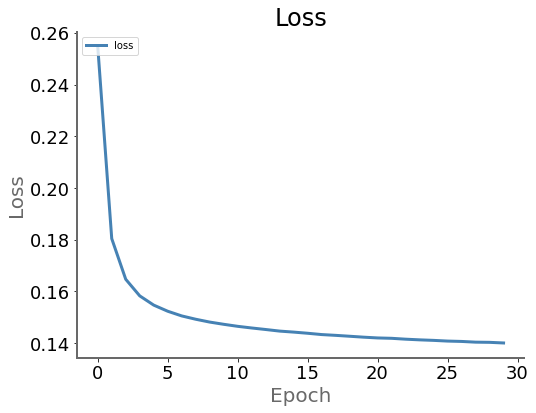

In [13]:
pwk.plot_history(history,  plot={"Loss":['loss']}, save_as='03-history')

## Step 7 - Learning progression

<br>**Real images :**

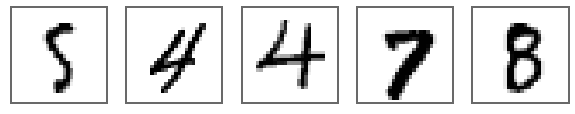

<br>**Noisy images :**

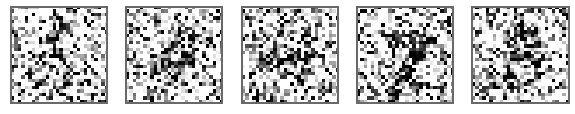

<br>**Learning...**

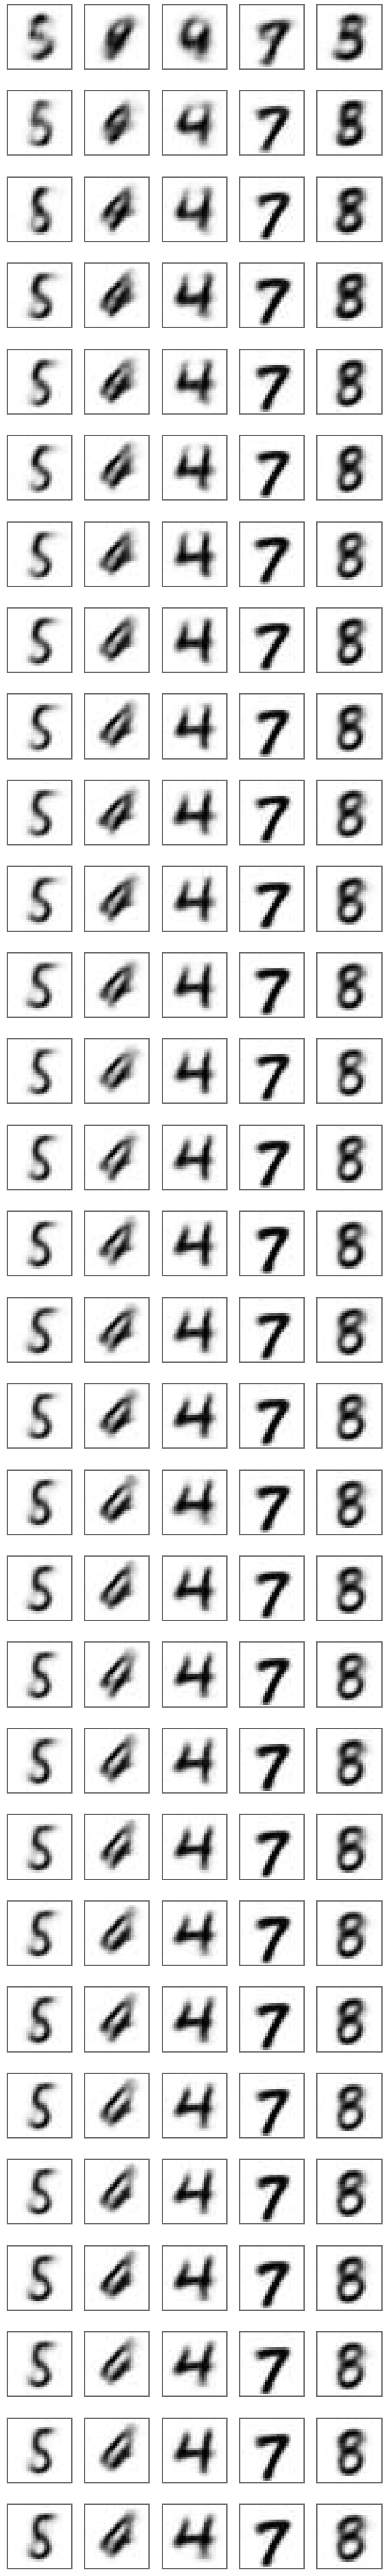

<br>**Noisy images :**

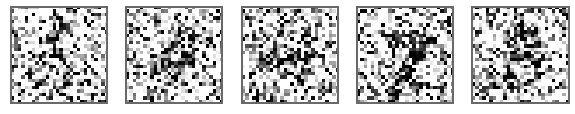

<br>**Real images :**

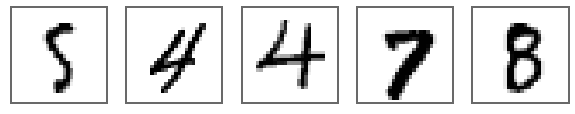

In [14]:
imgs=[]
labels=[]
for epoch in range(epochs):
    for i in range(5):
        filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='04-original-real')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='05-original-noisy')

pwk.subtitle('Learning...')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='06-learning')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


In [15]:
pwk.end()

End time is : Monday 01 March 2021, 20:34:53
Duration is : 00:02:11 233ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>